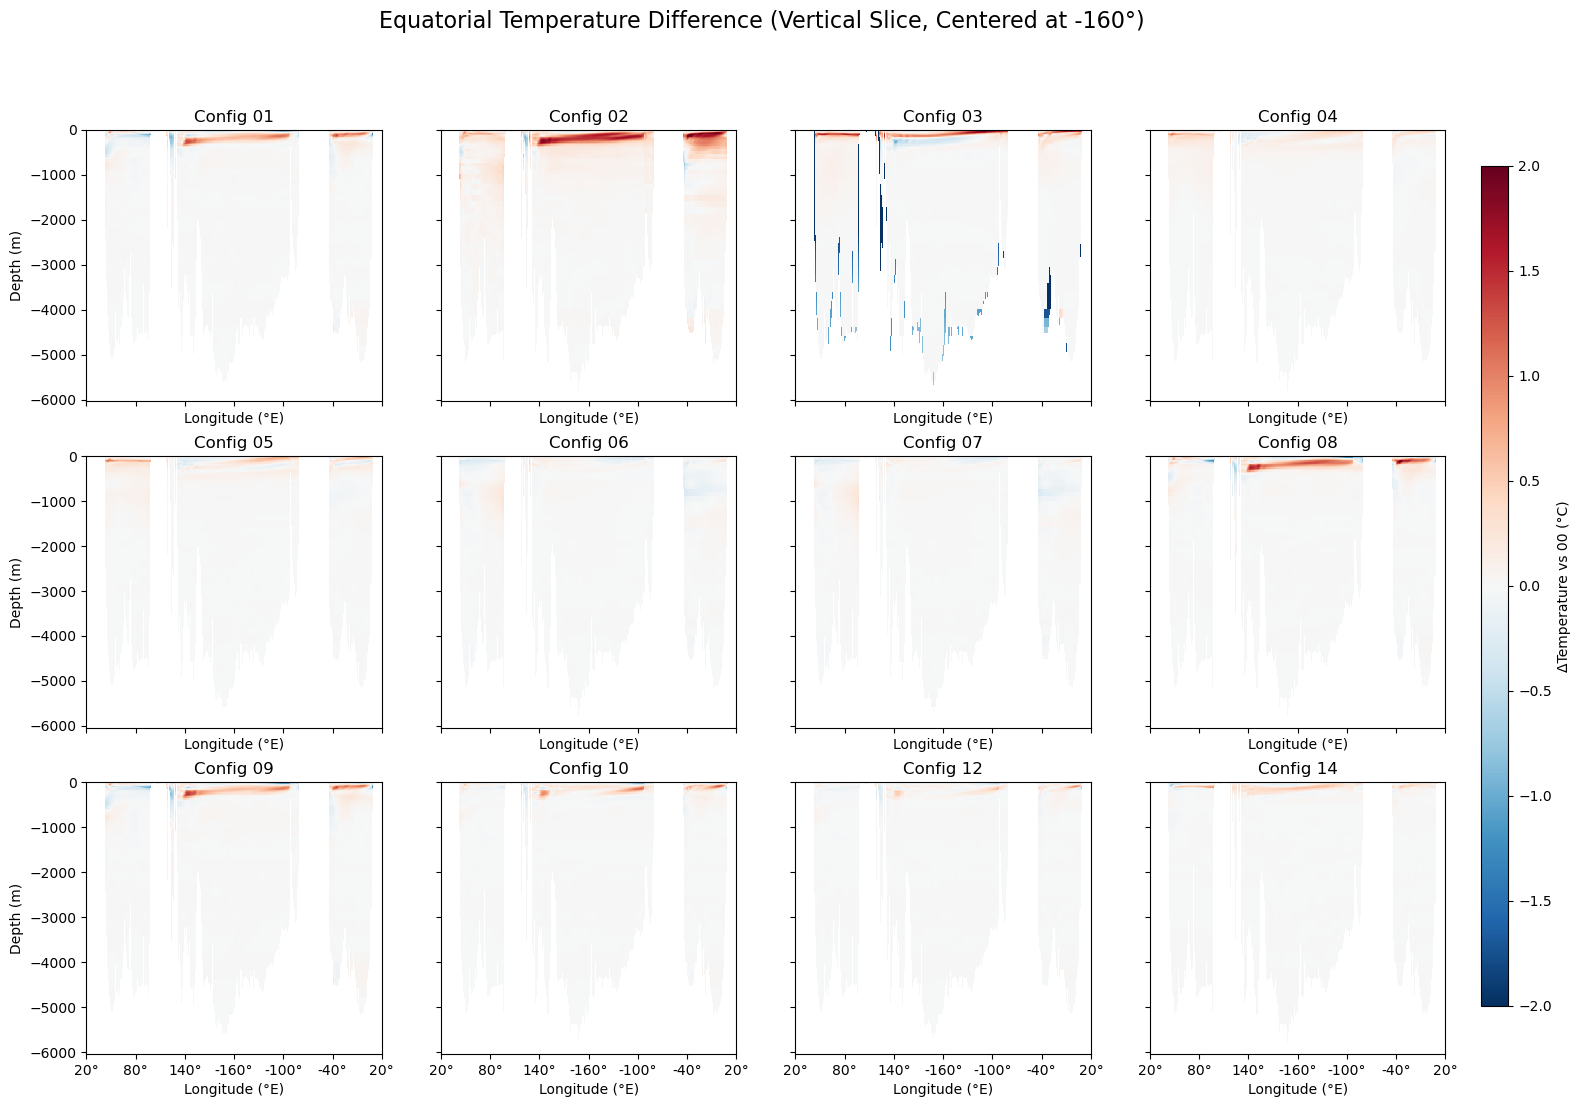

In [15]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# --- Paths and Constants ---
DATA_DIR = os.path.expanduser("~/NEMOCheck/data/model")
MESH_PATH = os.path.expanduser("~/NEMOCheck/data/model/orca05l75_domain_cfg_nemov5_10m.nc")
CFG_IDS = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "14"]
Y_EQ = 249  # Equator band index
CENTER_LON = -160  # Change this to your desired center longitude (e.g. -30, -160, 80, etc.)

def wrap180(lon):
    "Convert longitude to [-180, 180]."
    return ((lon + 180) % 360) - 180

def center_longitude(lon, center):
    """
    Shift and wrap longitude array so that 'center' is in the center of the plot.
    """
    shifted = ((lon - center + 180) % 360) - 180 + center
    return shifted

def get_grid_info(var, ds, mesh, y):
    dims = ds[var].dims
    nlev, nx = mesh.sizes["nav_lev"], mesh.sizes["x"]
    bottom = mesh.bottom_level.sel(y=y).values
    e3_1d = mesh.e3t_1d.values
    if "y_grid_T" in dims:
        nav_lon = mesh.glamf.sel(y=y).values
        e3_0 = mesh.e3t_0.sel(y=y).values
    elif "y_grid_U" in dims:
        nav_lon = mesh.glamt.sel(y=y).values
        e3_0 = mesh.e3u_0.sel(y=y).values
    else:
        raise ValueError(f"Unknown grid for {var} {dims}")

    valid_mask = np.zeros((nlev, nx), dtype=bool)
    for x in range(nx):
        valid_mask[:bottom[x], x] = True

    depth_2d = np.tile(e3_1d[:, None], (1, nx))
    for x in range(nx):
        level = bottom[x]
        depth_2d[level-1, x] = e3_0[level-1, x]  # e3_0 is (nlev, nx)

    depth_cumsum_2d = -np.cumsum(depth_2d, axis=0)
    sort_idx = np.argsort(nav_lon)
    depth_cumsum_2d_sorted = depth_cumsum_2d[:, sort_idx]
    depth_cumsum_2d_sorted_padded = np.pad(depth_cumsum_2d_sorted, ((1,0),(0,0)), 'constant')
    nav_lon_sorted = nav_lon[sort_idx]
    return dict(
        nav_lon=nav_lon,
        nav_lon_sorted=nav_lon_sorted,
        valid_mask=valid_mask,
        depth_cumsum_2d_sorted=depth_cumsum_2d_sorted,
        depth_cumsum_2d_sorted_padded=depth_cumsum_2d_sorted_padded,
        sort_idx=sort_idx,
        nlev=nlev,
        nx=nx
    )

# --- Load Mesh and Reference ---
mesh = xr.open_dataset(MESH_PATH)
ref_ds = xr.open_dataset(os.path.join(DATA_DIR, "nemo00_1m_201001_202212_Eq.nc"))
ref_temp = ref_ds["to"].mean("time_counter")
ref_lat, ref_lon = ref_ds["nav_lat_grid_T"], ref_ds["nav_lon_grid_T"]
equatorial_mask = (-1 <= ref_lat) & (ref_lat <= 1)
ref_eq_temp = ref_temp.where(equatorial_mask).mean("y_grid_T")

ref_grid = get_grid_info("to", ref_ds, mesh, Y_EQ)
sort_idx, nav_sorted = ref_grid["sort_idx"], ref_grid["nav_lon_sorted"]
depth_padded = ref_grid["depth_cumsum_2d_sorted_padded"]

# --- Center longitude for reference ---
nav_lon_centered = center_longitude(nav_sorted, CENTER_LON)
center_idx = np.argsort(nav_lon_centered)
nav_lon_centered = nav_lon_centered[center_idx]
depth_padded_centered = depth_padded[:, center_idx]
ref_eq_temp_centered = ref_eq_temp.values[:, sort_idx][:, center_idx]

# --- Plotting ---
fig, axs = plt.subplots(nrows=-(-len(CFG_IDS)//4), ncols=4, figsize=(18, 12), sharex=True, sharey=True)
axs = axs.flat

for i, cfg in enumerate(CFG_IDS):
    ds = xr.open_dataset(os.path.join(DATA_DIR, f"nemo{cfg}_1m_201001_202212_Eq.nc"))
    eq_temp = ds["to"].mean("time_counter").where(equatorial_mask).mean("y_grid_T")
    grid = get_grid_info("to", ds, mesh, Y_EQ)
    mask = grid["valid_mask"][:, sort_idx]
    eq_temp_centered = eq_temp.values[:, sort_idx][:, center_idx]
    diff = np.where(mask[:, center_idx], eq_temp_centered - ref_eq_temp_centered, np.nan)
    im = axs[i].pcolormesh(
        nav_lon_centered, depth_padded_centered, diff[:, 1:], 
        cmap="RdBu_r", vmin=-2, vmax=2, shading="auto"
    )
    axs[i].invert_yaxis()
    axs[i].set_title(f"Config {cfg}")
    axs[i].set_xlabel("Longitude (°E)")
    if i % 4 == 0:
        axs[i].set_ylabel("Depth (m)")
    xt = np.linspace(np.nanmin(nav_lon_centered), np.nanmax(nav_lon_centered), 7)
    axs[i].set_xticks(xt)
    axs[i].set_xticklabels([f"{wrap180(l):.0f}°" for l in xt])
    axs[i].set_xlim(np.nanmin(nav_lon_centered), np.nanmax(nav_lon_centered))

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label="ΔTemperature vs 00 (°C)")
fig.suptitle(f"Equatorial Temperature Difference (Vertical Slice, Centered at {wrap180(CENTER_LON):.0f}°)", fontsize=16)
plt.show()

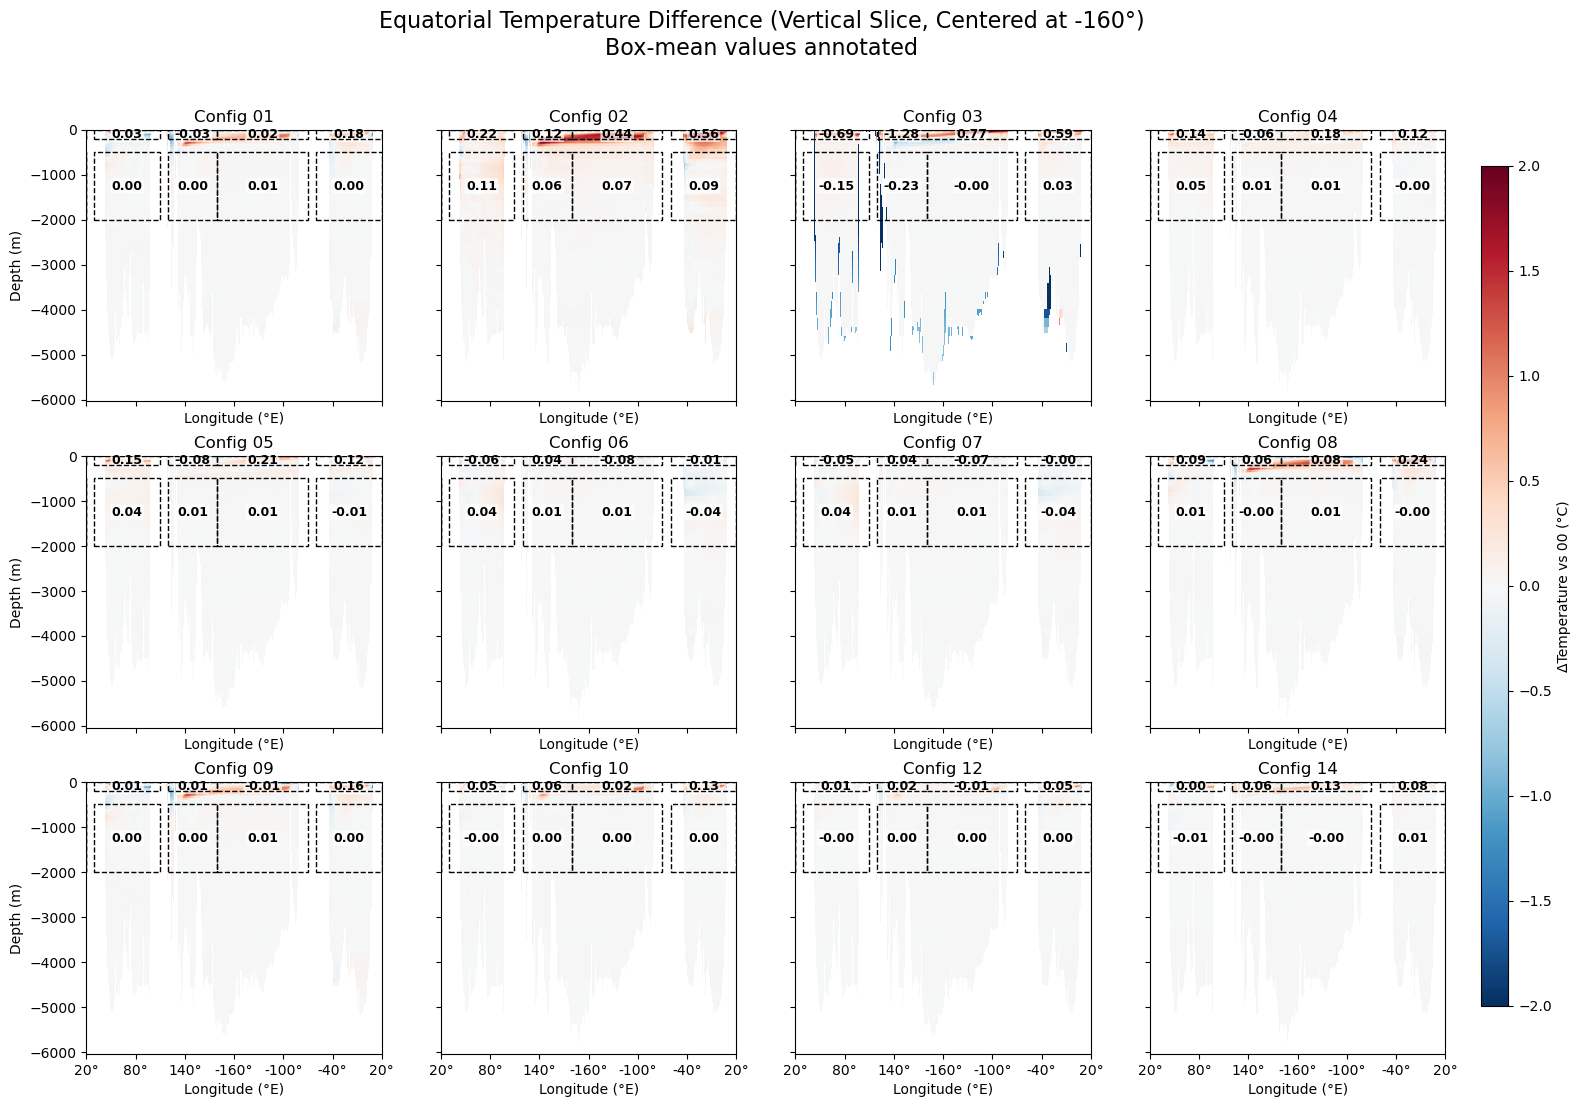

In [22]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# --- Paths and Constants ---
DATA_DIR = os.path.expanduser("~/NEMOCheck/data/model")
MESH_PATH = os.path.expanduser("~/NEMOCheck/data/model/orca05l75_domain_cfg_nemov5_10m.nc")
CFG_IDS = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "14"]
Y_EQ = 249  # Equator band index
CENTER_LON = -160  # Center longitude for the plot

# --- Define your boxes: (name, lon_min, lon_max, depth_min, depth_max) ---
# Longitudes in [-180, 180], depths negative down (e.g. -200, 0)
# For Pacific, split into two to avoid covering other oceans
BOXES = [
    ("Atlantic upper", -60, 20, -200, 0),
    ("Indian upper", 30, 110, -200, 0),
    ("Pacific W upper", 120, 180, -200, 0),
    ("Pacific E upper", -180, -70, -200, 0),
    ("Atlantic deep", -60, 20, -2000, -500),
    ("Indian deep", 30, 110, -2000, -500),
    ("Pacific W deep", 120, 180, -2000, -500),
    ("Pacific E deep", -180, -70, -2000, -500)
]

def wrap180(lon):
    "Convert longitude to [-180, 180]."
    return ((lon + 180) % 360) - 180

def center_longitude(lon, center):
    """Shift and wrap longitude array so that 'center' is in the center of the plot."""
    shifted = ((lon - center + 180) % 360) - 180 + center
    return shifted

def get_grid_info(var, ds, mesh, y):
    dims = ds[var].dims
    nlev, nx = mesh.sizes["nav_lev"], mesh.sizes["x"]
    bottom = mesh.bottom_level.sel(y=y).values
    e3_1d = mesh.e3t_1d.values
    if "y_grid_T" in dims:
        nav_lon = mesh.glamf.sel(y=y).values
        e3_0 = mesh.e3t_0.sel(y=y).values
    elif "y_grid_U" in dims:
        nav_lon = mesh.glamt.sel(y=y).values
        e3_0 = mesh.e3u_0.sel(y=y).values
    else:
        raise ValueError(f"Unknown grid for {var} {dims}")

    valid_mask = np.zeros((nlev, nx), dtype=bool)
    for x in range(nx):
        valid_mask[:bottom[x], x] = True

    depth_2d = np.tile(e3_1d[:, None], (1, nx))
    for x in range(nx):
        level = bottom[x]
        depth_2d[level-1, x] = e3_0[level-1, x]  # e3_0 is (nlev, nx)

    depth_cumsum_2d = -np.cumsum(depth_2d, axis=0)
    sort_idx = np.argsort(nav_lon)
    depth_cumsum_2d_sorted = depth_cumsum_2d[:, sort_idx]
    depth_cumsum_2d_sorted_padded = np.pad(depth_cumsum_2d_sorted, ((1,0),(0,0)), 'constant')
    nav_lon_sorted = nav_lon[sort_idx]
    return dict(
        nav_lon=nav_lon,
        nav_lon_sorted=nav_lon_sorted,
        valid_mask=valid_mask,
        depth_cumsum_2d_sorted=depth_cumsum_2d_sorted,
        depth_cumsum_2d_sorted_padded=depth_cumsum_2d_sorted_padded,
        sort_idx=sort_idx,
        nlev=nlev,
        nx=nx,
        depth_2d=depth_2d,
        depth_cumsum_2d=depth_cumsum_2d
    )

# --- Load Mesh and Reference ---
mesh = xr.open_dataset(MESH_PATH)
ref_ds = xr.open_dataset(os.path.join(DATA_DIR, "nemo00_1m_201001_202212_Eq.nc"))
ref_temp = ref_ds["to"].mean("time_counter")
ref_lat, ref_lon = ref_ds["nav_lat_grid_T"], ref_ds["nav_lon_grid_T"]
equatorial_mask = (-1 <= ref_lat) & (ref_lat <= 1)
ref_eq_temp = ref_temp.where(equatorial_mask).mean("y_grid_T")

ref_grid = get_grid_info("to", ref_ds, mesh, Y_EQ)
sort_idx, nav_sorted = ref_grid["sort_idx"], ref_grid["nav_lon_sorted"]
depth_padded = ref_grid["depth_cumsum_2d_sorted_padded"]
depth_cumsum_2d = ref_grid["depth_cumsum_2d"]
depth_axis = np.mean(depth_cumsum_2d, axis=1)

# --- Center longitude for reference ---
nav_lon_centered = center_longitude(nav_sorted, CENTER_LON)
center_idx = np.argsort(nav_lon_centered)
nav_lon_centered = nav_lon_centered[center_idx]
depth_padded_centered = depth_padded[:, center_idx]
ref_eq_temp_centered = ref_eq_temp.values[:, sort_idx][:, center_idx]

# --- Plotting ---
fig, axs = plt.subplots(nrows=-(-len(CFG_IDS)//4), ncols=4, figsize=(18, 12), sharex=True, sharey=True)
axs = axs.flat

for i, cfg in enumerate(CFG_IDS):
    ds = xr.open_dataset(os.path.join(DATA_DIR, f"nemo{cfg}_1m_201001_202212_Eq.nc"))
    eq_temp = ds["to"].mean("time_counter").where(equatorial_mask).mean("y_grid_T")
    grid = get_grid_info("to", ds, mesh, Y_EQ)
    mask = grid["valid_mask"][:, sort_idx]
    eq_temp_centered = eq_temp.values[:, sort_idx][:, center_idx]
    diff = np.where(mask[:, center_idx], eq_temp_centered - ref_eq_temp_centered, np.nan)
    im = axs[i].pcolormesh(
        nav_lon_centered, depth_padded_centered, diff[:, 1:], 
        cmap="RdBu_r", vmin=-2, vmax=2, shading="auto"
    )
    axs[i].invert_yaxis()
    axs[i].set_title(f"Config {cfg}")
    axs[i].set_xlabel("Longitude (°E)")
    if i % 4 == 0:
        axs[i].set_ylabel("Depth (m)")
    xt = np.linspace(np.nanmin(nav_lon_centered), np.nanmax(nav_lon_centered), 7)
    axs[i].set_xticks(xt)
    axs[i].set_xticklabels([f"{wrap180(l):.0f}°" for l in xt])
    axs[i].set_xlim(np.nanmin(nav_lon_centered), np.nanmax(nav_lon_centered))

    # --- Compute and visualize mean difference in each box (robust against empty slices) ---
    for box in BOXES:
        name, lon_min, lon_max, depth_min, depth_max = box
    
        # --- Center the box bounds to match the centered longitude grid ---
        box_lon_min = center_longitude(np.array([lon_min]), CENTER_LON)[0]
        box_lon_max = center_longitude(np.array([lon_max]), CENTER_LON)[0]
    
        # Check if the box wraps (now, in centered coords)
        if box_lon_min < box_lon_max:
            lon_mask = (nav_lon_centered >= box_lon_min) & (nav_lon_centered <= box_lon_max)
            rects = [ (box_lon_min, box_lon_max) ]
        else:
            lon_mask = (nav_lon_centered >= box_lon_min) | (nav_lon_centered <= box_lon_max)
            rects = [
                (box_lon_min, np.nanmax(nav_lon_centered)),
                (np.nanmin(nav_lon_centered), box_lon_max)
            ]
        depth_mask = (depth_axis > depth_min) & (depth_axis <= depth_max)
        box_vals = diff[depth_mask, :][:, lon_mask]
        valid_vals = box_vals[np.isfinite(box_vals)]
        if valid_vals.size > 0:
            mean_val = np.mean(valid_vals)
            # For split Pacific, text at each box's center (centered coordinates)
            box_lon_center = (box_lon_min + box_lon_max)/2 if box_lon_min < box_lon_max else wrap180(((box_lon_min + (box_lon_max+360))/2))
            box_depth_center = (depth_min + depth_max)/2
            axs[i].text(
                box_lon_center, box_depth_center,
                f"{mean_val:.2f}", color="black", fontsize=9, fontweight="bold",
                ha="center", va="center", bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle="round,pad=0.1")
            )
        # Draw rectangles on the centered grid
        for lo, hi in rects:
            axs[i].add_patch(
                plt.Rectangle(
                    (lo, depth_min), hi-lo, depth_max-depth_min,
                    edgecolor="k", facecolor="none", lw=1.0, linestyle='--', zorder=10
                )
            )

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label="ΔTemperature vs 00 (°C)")
fig.suptitle(f"Equatorial Temperature Difference (Vertical Slice, Centered at {wrap180(CENTER_LON):.0f}°)\nBox-mean values annotated", fontsize=16)
plt.show()

# Idea
- imshow for moved picture on purpose
- significant boxes in a color
- RMSE and not mean